### Utilizing undirected graphs to determine the shortest path in Open Street Map data

In [22]:
from shapely.geometry import shape
import fiona
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import pandas as pd
import contextily as cx
import numpy as np

In [23]:
# Downloading Open Street Map files from https://download.geofabrik.de/
shape_dir = "./dane/drogi_sopot.shp"
geoms = [shape(feature['geometry']) for feature in fiona.open(shape_dir )]
roads = gpd.read_file(shape_dir)

# Zamiana brakujacych nazw ulic
roads['name'][roads['name'].isna()]  = 'no_name'

C:\Users\domin\anaconda3\envs\graf\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


###  Transformation of path vectors into graphs
The transformation is done by converting the geometric representation of the geometry in CCI format (coordinate pairs) to the form of connected calls and connecting edges.

In [24]:
# Initialize graph
G = nx.Graph()

# Counter for roads
road_index = 0

# Counter for segments
segment_counter = 0

# Iterate over all geometries
for line in geoms:
    # Get the current road data
    current_road = roads.iloc[[road_index]]
    road_index += 1

    # Iterate over pairs of coordinates forming segments
    for seg_start, seg_end in zip(line.coords, line.coords[1:]):
        segment_counter += 1
        G.add_edge(
            seg_start,
            seg_end,
            N=segment_counter,
            weight=current_road['maxspeed'].values[0], 
            street=current_road['name'].values[0],
            osm_id=current_road['code'].values[0]
        )


### Selecting a starting and ending point to determine the shortest route
We can choose any street to determine the shortest route between them. </br>
Downtown Sopot was chosen as the area of interest. </br>

In [63]:
#Wszystkie nazwy ulic dostępne w obszarze zaintersesowania 
unique_streets = roads['name'].unique()


In [39]:
def get_start_end_point(Graph, data, start_point, end_point):
    """
    Finds the source and target nodes in a graph based on the street names
    (start_point and end_point), and collects edge weights and labels.

    Parameters:
    - Graph: networkx.Graph
        The graph containing nodes and edges with attributes.
    - start_point: str
        The name of the street representing the starting point.
    - end_point: str
        The name of the street representing the ending point.

    Returns:
    - source: Any
        The source node corresponding to the start_point street name.
    - target: Any
        The target node corresponding to the end_point street name.
    - W: list
        A list of weights of all edges in the graph.
    - lbl: list
        A list of labels (edge attribute 'N') of all edges in the graph.
    """

    # Initialize variables
    source = None
    target = None
    edge_weights = []
    edge_labels = []

    # Iterate over all edges in the graph with their data
    for node1, node2, data in Graph.edges(data=True):
        # Append the edge weight to the list
        edge_weights.append(data['weight'])
        # Append the edge label 'N' to the list
        edge_labels.append(data['N'])

        # Check if the street name matches the start point
        if data['street'] == start_point:
            source = node1
        # Check if the street name matches the end point
        elif data['street'] == end_point:
            target = node1

    return source, target, edge_weights, edge_labels


### Determining the shortest route between points.

In [40]:
def euclidean_distance(pt_1, pt_2):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    - pt_1: array-like
        Coordinates of the first point (e.g., [x1, y1]).
    - pt_2: array-like
        Coordinates of the second point (e.g., [x2, y2]).

    Returns:
    - float
        The Euclidean distance between the two points.
    """
    # Convert input points to numpy arrays
    pt_1 = np.array(pt_1)
    pt_2 = np.array(pt_2)
    
    # Calculate and return the Euclidean distance
    return np.linalg.norm(pt_1 - pt_2)


def get_path_attributes(route, data, G):
    """
    Extracts path attributes such as distances between nodes, street names, 
    and speed limits from a given route in a graph.

    Parameters:
    - route: list
        A list of nodes representing the route in the graph.
    - G: networkx.Graph
        The graph containing nodes and edges with attributes such as 'ulica' and 'weight'.

    Returns:
    - list_of_distances: list
        A list of Euclidean distances between consecutive nodes in the route.
    - streets_name: numpy.ndarray
        An array of unique street names encountered along the route.
    - speed_limit: numpy.ndarray
        An array of speed limits corresponding to the unique streets in the route.
    """
    
    list_of_distances = []
    streets_name = []
    speed_limit = []
    
    # Iterate over the route to gather attributes
    for i in range(len(route) - 1):
        # Get edge data between consecutive nodes
        data = G.get_edge_data(route[i], route[i + 1])

        # Check if the street name is already added to streets_name
        if data['street'] not in streets_name:
            streets_name.append(data['street'])
            speed_limit.append(data['weight'])

        # Calculate the Euclidean distance between consecutive nodes
        xy_node1 = np.array(route[i]).reshape((1, 2))
        xy_node2 = np.array(route[i + 1]).reshape((1, 2))  # Use (1, 2) to ensure consistent reshaping
        nodes_distance = euclidean_distance(xy_node1, xy_node2)
        list_of_distances.append(nodes_distance)

    # Calculate the total path distance
    path_distance = np.round(np.sum(list_of_distances), 2)
    
    # Convert lists to numpy arrays for output consistency
    streets_name = np.array(streets_name, dtype=str)
    speed_limit = np.array(speed_limit, dtype=int)
    
    return list_of_distances, streets_name, speed_limit


In [56]:
## Start and end point of the route
street_start = 'Fryderyka Chopina'
street_end = 'Aleja Agnieszki Osieckiej'

source, target, W, lbl = get_start_end_point(G, roads, street_start, street_end)

In [57]:
# Determination of the shortest route from the starting point to the ending point using the Dijkstra algorithm method.
route = nx.shortest_path(G, source = source, target = target, method ='dijkstra' )

### Description of the attributes of the designated route - the total distance and its route.

In [58]:
list_of_distances, streets_name, speed_limit = get_path_attributes(route, roads, G)

In [59]:
path_distance = np.round(np.sum(np.array(list_of_distances).reshape((-1)), axis = 0), 2)

In [60]:
print(f"Shortest walking distance from street: {street_start} to {street_end} is {path_distance}m")

Shortest walking distance from street: Fryderyka Chopina to Aleja Agnieszki Osieckiej is 1365.25m


In [61]:
print("The designated route runs successively through the places:")
trasa = [print(f" - {x}") for x in streets_name] 

The designated route runs successively through the places:
 - Fryderyka Chopina
 - no_name
 - Generała Stanisława Fiszera
 - Generała Kazimierza Pułaskiego
 - Generała Józefa Bema
 - Bohaterów Monte Cassino
 - Jana Jerzego Haffnera
 - Mariana Mokwy
 - Aleja Agnieszki Osieckiej


### Visualize the results
Visualization of the route and graph from the street layout </br>

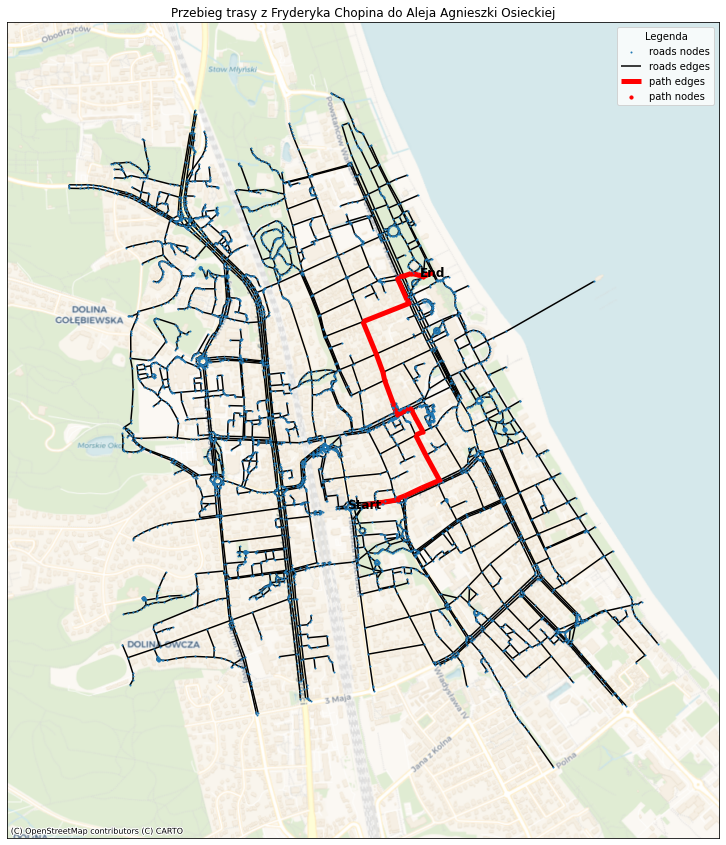

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(15,15),  sharex = True, sharey=True)

##  Displaying the entire graph
pos =  dict(zip(G.nodes(), G.nodes()))
nx.draw_networkx_nodes(G, pos, node_size = 1,  ax = ax)
nx.draw_networkx_edges(G, pos, ax = ax, width = 1.5, edge_cmap= plt.cm.Blues)

#### Displaying the route
i = G.subgraph(route)
pos =  dict(zip(i.nodes(), i.nodes()))
nx.draw_networkx_edges(i, pos = pos, edge_color = 'r', width = 5.0 , ax = ax)
nx.draw_networkx_nodes(i, pos = pos, node_size = 10, node_color = 'r', ax = ax)

# Text labels
ax.text(source[0], source[1], "Start",
        color = 'k', ha = 'center', 
        va = 'center', 
        fontdict = {"fontsize":'large',"fontweight":"bold"})

ax.text(target[0], target[1], "End", 
        color = 'k', ha = 'center', 
        va = 'center', 
        fontdict = {"fontsize":'large',"fontweight":"bold"})

plt.legend(["roads nodes", 'roads edges', 'path edges', 
            'path nodes', 'start node', 'end node'],
           title='Legend', loc = 'upper right')


try:
    cx.add_basemap(ax, crs = "EPSG:2180", source=cx.providers.CartoDB.Voyager)
except Exception as e:
    print("No network connection")
    print(e)
    
plt.title(f"Routing from {street_start} to {street_end}")
plt.show()